In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


In [2]:
########### ---------------- Import the data ---------------- ###########

# original data:
real_samples = pd.read_csv('data/sliced_data.csv')

# keep 1000 random samples using the module random
real_samples = real_samples.sample(n=1000, random_state=1)

# generated data:
generated_samples = pd.read_csv('data/GAN3_generated_slices.csv')

# keep 1000 random samples from the generated data
generated_samples = generated_samples.sample(n=1000, random_state=1)

print(real_samples.shape)
print(generated_samples.shape)



(1000, 60)
(1000, 60)


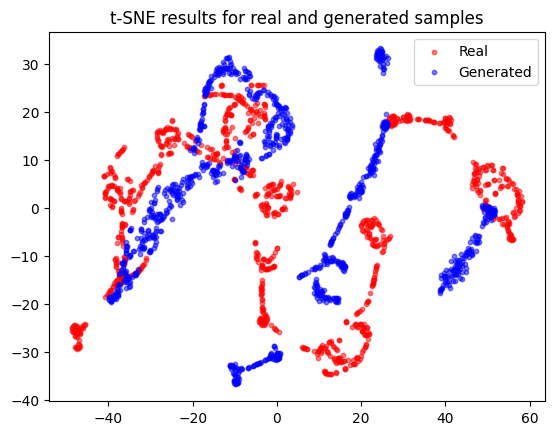

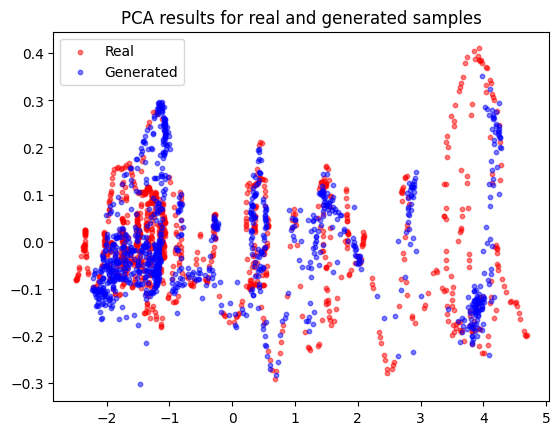

In [3]:
########### ---------------- t-SNE ---------------- ###########

def time_series_to_2d_points(time_series):
    # Initialize t-SNE
    tsne = TSNE(n_components=2)

    # Fit and transform the data to the first two components
    two_d_points = tsne.fit_transform(time_series)

    return two_d_points


def time_series_to_2d_points_pca(time_series):
    # Initialize PCA
    pca = PCA(n_components=2)

    # Fit and transform the data to the first two components
    two_d_points = pca.fit_transform(time_series)

    return two_d_points


# Convert the samples to 2D points
real_points = time_series_to_2d_points(real_samples)
generated_points = time_series_to_2d_points(generated_samples)

# Plot the t-SNE results
plt.scatter(real_points[:, 0], real_points[:, 1], color='red', label='Real', s=10, alpha=0.5)
plt.scatter(generated_points[:, 0], generated_points[:, 1], color='blue', label='Generated', s=10,alpha=0.5)
plt.legend() 
# Add a title
plt.title('t-SNE results for real and generated samples')

plt.show()

# Convert the samples to 2D points using PCA
real_points_pca = time_series_to_2d_points_pca(real_samples)
generated_points_pca = time_series_to_2d_points_pca(generated_samples)

# Plot the PCA results
plt.scatter(real_points_pca[:, 0], real_points_pca[:, 1], color='red', label='Real', s=10, alpha=0.5)
plt.scatter(generated_points_pca[:, 0], generated_points_pca[:, 1], color='blue', label='Generated', s=10, alpha=0.5)
plt.legend() 
# Add a title
plt.title('PCA results for real and generated samples')

plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

def train_test_divide(dataX, dataX_hat):
    trainX, testX = train_test_split(dataX, test_size=0.2, random_state=42)
    trainX_hat, testX_hat = train_test_split(dataX_hat, test_size=0.2, random_state=42)
    return trainX, trainX_hat, testX, testX_hat

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        out = self.fc2(h)
        return out, self.sigmoid(out)

def discriminative_score_metrics(dataX, dataX_hat):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0])

    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 2000
    batch_size = 128

    model = Discriminator(data_dim, hidden_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())

    # Train / Test Division
    trainX, trainX_hat, testX, testX_hat = train_test_divide(dataX, dataX_hat)

    # Training step
    for itt in range(iterations):
        model.train()
        optimizer.zero_grad()

        # Batch setting
        idx = np.random.permutation(len(trainX))[:batch_size]
        X_mb = torch.stack([trainX[i] for i in idx]).to(device)

        # Batch setting
        idx = np.random.permutation(len(trainX_hat))[:batch_size]
        X_hat_mb = torch.stack([trainX_hat[i] for i in idx]).to(device)

        # Train discriminator
        Y_real, Y_pred_real = model(X_mb)
        Y_fake, Y_pred_fake = model(X_hat_mb)

        D_loss_real = criterion(Y_real, torch.ones_like(Y_real))
        D_loss_fake = criterion(Y_fake, torch.zeros_like(Y_fake))
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        optimizer.step()

    # Final Outputs (on Testing set)
    model.eval()
    with torch.no_grad():
        Y_real, Y_pred_real = model(torch.tensor(testX).to(device))
        Y_fake, Y_pred_fake = model(torch.tensor(testX_hat).to(device))

    Y_pred_final = torch.cat((Y_pred_real, Y_pred_fake), dim=0).cpu().numpy()
    Y_label_final = np.concatenate((np.ones([len(Y_pred_real),]), np.zeros([len(Y_pred_real),])), axis = 0)

    # Accuracy
    Acc = accuracy_score(Y_label_final, Y_pred_final>0.5)

    Disc_Score = np.abs(0.5-Acc)

    return Disc_Score

In [5]:
# compute the mean and std of the real samples
mean_real = real_samples.mean().mean()
std_real = real_samples.std().mean()

# print the mean and std of the real samples
print(f'Mean of the real samples: {mean_real}')
print(f'Std of the real samples: {std_real}')

# same for the generated samples
mean_generated = generated_samples.mean().mean()
std_generated = generated_samples.std().mean()

# print the mean and std of the generated samples
print(f'Mean of the generated samples: {mean_generated}')
print(f'Std of the generated samples: {std_generated}')



Mean of the real samples: 0.33660239691290694
Std of the real samples: 0.25790637188655635
Mean of the generated samples: 0.33375413554129746
Std of the generated samples: 0.2573188331841874


In [6]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

real_samples_array = np.array(real_samples)
generated_samples_array = np.array(generated_samples)

# put them as tensors
real_samples_tensors = torch.tensor(real_samples_array)
generated_samples_tensors = torch.tensor(generated_samples_array)

# put them both as floats
real_samples_tensors = real_samples_tensors.float()
generated_samples_tensors = generated_samples_tensors.float()

scores = []
for i in range(10):

    # Now you can call the function
    disc_score = discriminative_score_metrics(real_samples_tensors, generated_samples_tensors)
    scores.append(disc_score)

mean = np.mean(scores)
std = np.std(scores)

print('Mean Discriminative Score: %.4f' % mean)
print('Standard Deviation of Discriminative Score: %.4f' % std)

Mean Discriminative Score: 0.0822
Standard Deviation of Discriminative Score: 0.0358


In [7]:
# # Assuming real_samples is a numpy array
# time_steps = np.arange(1, 61)  # Create a list of integers from 1 to 60

# # Create a new array to hold the samples with time steps
# real_samples_with_time = np.empty((real_samples.shape[0], real_samples.shape[1], 2))

# # Iterate over the rows of real_samples
# for i in range(real_samples.shape[0]):
#     real_samples_with_time[i] = np.column_stack((real_samples[i, :, np.newaxis], time_steps))

# # Create a new array to hold the samples with time steps
# generated_samples_with_time = np.empty((generated_samples.shape[0], generated_samples.shape[1], 2))

# # Iterate over the rows of generated_samples
# for i in range(generated_samples.shape[0]):
#     generated_samples_with_time[i] = np.column_stack((generated_samples[i, :, np.newaxis], time_steps))

# generated_samples = generated_samples_with_time
# real_samples = real_samples_with_time

In [8]:
# import torch
# import torch.nn as nn
# import numpy as np
# from sklearn.metrics import mean_absolute_error
# from tqdm import tqdm

# class Predictor(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(Predictor, self).__init__()
#         self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, 1)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out[:, -1, :])
#         return torch.sigmoid(out)

# def predictive_score_metrics(dataX, dataX_hat):
#     # Basic Parameters
#     No = len(dataX)
#     data_dim = len(dataX[0][0,:])

#     # Network Parameters
#     hidden_dim = max(int(data_dim/2),1)
#     iterations = 5000 # cahnge this afterwwards
#     batch_size = 128

#     # Convert data to PyTorch tensors if they are numpy arrays
#     if isinstance(dataX, np.ndarray):
#         dataX = torch.from_numpy(dataX).float()
#     if isinstance(dataX_hat, np.ndarray):
#         dataX_hat = torch.from_numpy(dataX_hat).float()

#     # Initialize the model, loss function and optimizer
#     model = Predictor(data_dim, hidden_dim)
#     criterion = nn.L1Loss()
#     optimizer = torch.optim.Adam(model.parameters())

#     # Train the model on the synthetic data
#     for itt in tqdm(range(iterations)):
#         idx = torch.randperm(len(dataX_hat))[:batch_size]
#         X_mb = dataX_hat[idx, :-1]
#         Y_mb = dataX_hat[idx, 1:, -1]
#         pred_Y = model(X_mb)
#         loss = criterion(pred_Y, Y_mb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Evaluate the model on the original data
#     X_mb = dataX[:, :-1]
#     Y_mb = dataX[:, -1, -1]
#     pred_Y = model(X_mb)

#     MAE = mean_absolute_error(Y_mb.detach().numpy(), pred_Y.detach().numpy())
#     return MAE    

In [9]:
# # now we test the function
# predictive_score = predictive_score_metrics(real_samples, generated_samples)

# print('Predictive Score: %.4f' % predictive_score)

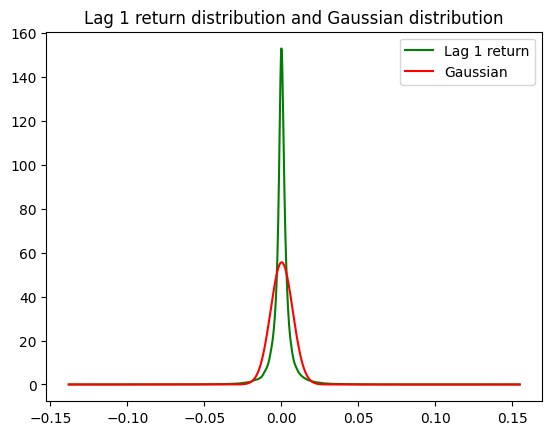

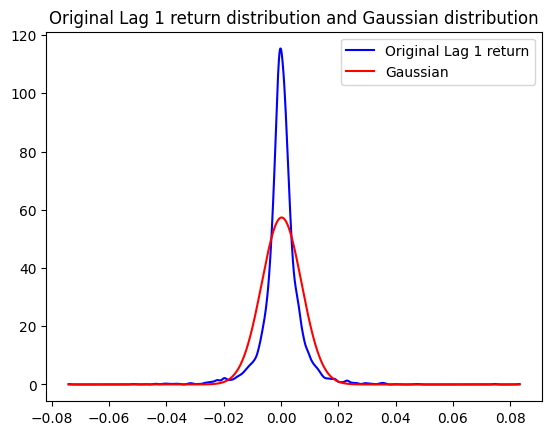

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

# Calculate the lag 1 return for each time series
lag_1_returns = [np.diff(time_series) for time_series in generated_samples.values]

# Flatten the returns to 1D
lag_1_returns = np.concatenate(lag_1_returns)

# Calculate the mean and standard deviation of the returns
mean = np.mean(lag_1_returns)
std = np.std(lag_1_returns)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian = norm(loc=mean, scale=std)

# Generate values for the x axis
x = np.linspace(min(lag_1_returns), max(lag_1_returns), 1000)

# Estimate the density function of the lag 1 return using KDE
kde = gaussian_kde(lag_1_returns)
lag_1_return_density = kde(x)

# Plot the density function of the lag 1 return
plt.plot(x, lag_1_return_density, color='g', label='Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x, gaussian.pdf(x), 'r', label='Gaussian')

plt.title('Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

# Calculate the lag 1 return for each slicing window
lag_1_returns_original = [np.diff(time_series) for time_series in real_samples.values]

# Flatten the returns to 1D
lag_1_returns_original = np.concatenate(lag_1_returns_original)

# Calculate the mean and standard deviation of the returns
mean_original = np.mean(lag_1_returns_original)
std_original = np.std(lag_1_returns_original)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian_original = norm(loc=mean_original, scale=std_original)

# Generate values for the x axis
x_original = np.linspace(min(lag_1_returns_original), max(lag_1_returns_original), 1000)

# Estimate the density function of the lag 1 return using KDE
kde_original = gaussian_kde(lag_1_returns_original)
lag_1_return_density_original = kde_original(x_original)

# Plot the density function of the lag 1 return
plt.plot(x_original, lag_1_return_density_original, color='b', label='Original Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x_original, gaussian_original.pdf(x_original), 'r', label='Gaussian')

plt.title('Original Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

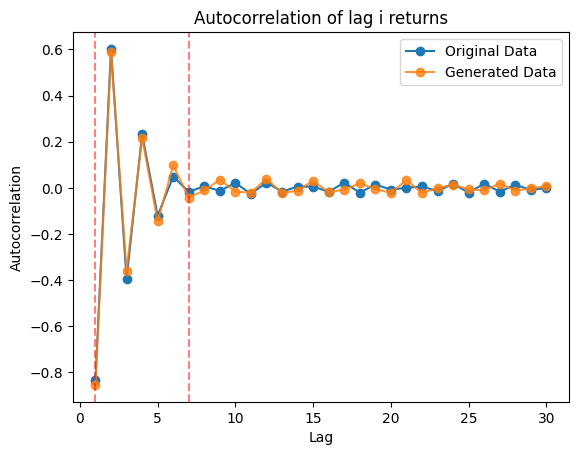

In [11]:
from statsmodels.tsa.stattools import acf


# Calculate the lag i return for each slicing window
lag_returns_original = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in real_samples.values]

# Exclude short time series
lag_returns_original = [lag_return for lag_return in lag_returns_original if len(lag_return) >= 31]

# Calculate the autocorrelation for each lag
autocorrelations = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_original]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_original = np.mean(autocorrelations, axis=0)[1:]



# Calculate the lag i return for each generated time series
lag_returns_generated = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in generated_samples.values]

# Exclude short time series
lag_returns_generated = [lag_return for lag_return in lag_returns_generated if len(lag_return) >= 31]

# Calculate the autocorrelation for each lag
autocorrelations_generated = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_generated = np.mean(autocorrelations_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.plot(range(1, 31), mean_autocorrelations_original, marker='o', label='Original Data')
plt.plot(range(1, 31), mean_autocorrelations_generated, marker='o', label='Generated Data', alpha=0.8)

# Add vertical lines at lag = 1 and lag = 7
plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=7, color='r', linestyle='--', alpha=0.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of lag i returns')
plt.legend()
plt.show()

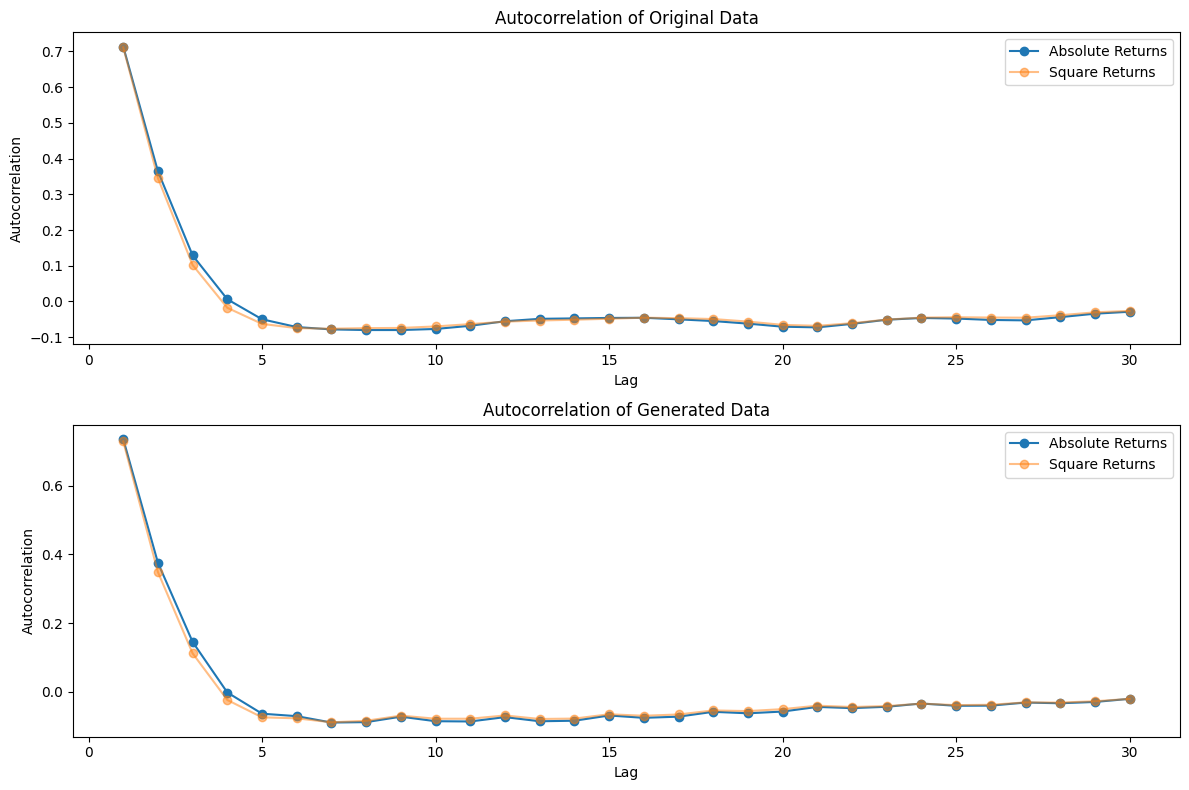

In [12]:
# Calculate the absolute and square returns
abs_returns_original = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in real_samples_array]
sq_returns_original = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in real_samples_array]

abs_returns_generated = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in generated_samples_array]
sq_returns_generated = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in generated_samples_array]

# Exclude short time series
abs_returns_original = [abs_return for abs_return in abs_returns_original if len(abs_return) >= 31]
sq_returns_original = [sq_return for sq_return in sq_returns_original if len(sq_return) >= 31]

abs_returns_generated = [abs_return for abs_return in abs_returns_generated if len(abs_return) >= 31]
sq_returns_generated = [sq_return for sq_return in sq_returns_generated if len(sq_return) >= 31]


# Calculate the autocorrelation for each lag
autocorrelations_abs_original = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_original]
autocorrelations_sq_original = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_original]

autocorrelations_abs_generated = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_generated]
autocorrelations_sq_generated = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_abs_original = np.mean(autocorrelations_abs_original, axis=0)[1:]
mean_autocorrelations_sq_original = np.mean(autocorrelations_sq_original, axis=0)[1:]

mean_autocorrelations_abs_generated = np.mean(autocorrelations_abs_generated, axis=0)[1:]
mean_autocorrelations_sq_generated = np.mean(autocorrelations_sq_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range(1, 31), mean_autocorrelations_abs_original, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_original, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Original Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, 31), mean_autocorrelations_abs_generated, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_generated, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Generated Data')
plt.legend()

plt.tight_layout()
plt.show()

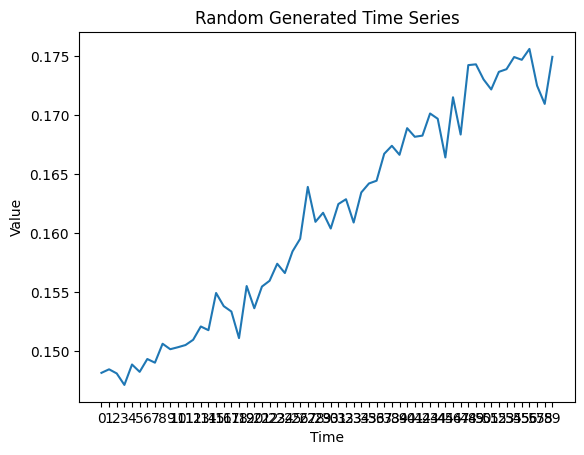

In [13]:
# Select a random time series from the generated data
random_index = np.random.randint(generated_samples.shape[0])
random_series = generated_samples.iloc[random_index]
# Plot the time series
plt.plot(random_series)
plt.title('Random Generated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()